## ETL on `OpenPowerlifting` Data

In [1]:
from IPython.display import display, Markdown
import polars as pl 
from datetime import datetime as dt

# read configs 
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from steps import conf

### Loading Data

In [2]:
s3_file_path = f"https://{conf.bucket_name}.s3.ap-southeast-2.amazonaws.com/{conf.parquet_file}"

df = pl.read_parquet(s3_file_path)
df.head(5)

Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
str,str,str,str,f64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str
"""Alona Vladi""","""F""","""SBD""","""Raw""",33.0,"""24-34""","""24-39""","""O""",58.3,"""60""",75.0,80.0,-90.0,null,80.0,50.0,55.0,60.0,null,60.0,95.0,105.0,107.5,null,107.5,247.5,"""1""",279.44,282.18,249.42,57.1,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Galina Solovya…","""F""","""SBD""","""Raw""",43.0,"""40-44""","""40-49""","""M1""",73.1,"""75""",95.0,100.0,105.0,null,105.0,62.5,67.5,-72.5,null,67.5,100.0,110.0,-120.0,null,110.0,282.5,"""1""",278.95,272.99,240.35,56.76,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Daniil Voronin…","""M""","""SBD""","""Raw""",15.5,"""16-17""","""14-18""","""T""",67.4,"""75""",85.0,90.0,100.0,null,100.0,55.0,62.5,-65.0,null,62.5,90.0,100.0,105.0,null,105.0,267.5,"""1""",206.4,206.49,200.45,41.24,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Aleksey Krasov…","""M""","""SBD""","""Raw""",35.0,"""35-39""","""24-39""","""O""",66.65,"""75""",125.0,132.0,137.5,null,137.5,115.0,122.5,-127.5,null,122.5,150.0,165.0,170.0,null,170.0,430.0,"""1""",334.49,334.94,325.32,66.68,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Margarita Ples…","""M""","""SBD""","""Raw""",26.5,"""24-34""","""24-39""","""O""",72.45,"""75""",80.0,85.0,90.0,null,90.0,40.0,50.0,-60.0,null,50.0,112.5,120.0,125.0,null,125.0,265.0,"""1""",194.46,193.55,187.29,39.34,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"


In [3]:
cleansing_data_md = f"""
## Cleansing data
- Filter for only particular columns from {conf.op_cols}
    - Select events that are IPF / Tested federations only (i.e. `Tested` = "Yes")
    - Remove anyone who has been disqualified (i.e. `Place` = "DQ")
    - `raw` equipment events only (i.e. `equipment` = `Raw`, single ply and wraps have 'competitive' advantage and are typically only for advanced lifters)
- Drop any rows that have missing values in the columns above.
- Drop any duplicates based on all columns.
"""

display(Markdown(cleansing_data_md))


## Cleansing data
- Filter for only particular columns from ['Date', 'Name', 'Sex', 'Place', 'Age', 'AgeClass', 'BodyweightKg', 'Event', 'MeetCountry', 'Equipment', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Wilks', 'Tested', 'Federation', 'MeetName']
    - Select events that are IPF / Tested federations only (i.e. `Tested` = "Yes")
    - Remove anyone who has been disqualified (i.e. `Place` = "DQ")
    - `raw` equipment events only (i.e. `equipment` = `Raw`, single ply and wraps have 'competitive' advantage and are typically only for advanced lifters)
- Drop any rows that have missing values in the columns above.
- Drop any duplicates based on all columns.


In [4]:
base_df = df.select(conf.op_cols)
print(base_df.shape)
base_df.head(5)

(2907777, 18)


Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,Event,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested,Federation,MeetName
str,str,str,str,f64,str,f64,str,str,str,f64,f64,f64,f64,f64,str,str,str
"""2019-05-11""","""Alona Vladi""","""F""","""1""",33.0,"""24-34""",58.3,"""SBD""","""Russia""","""Raw""",80.0,60.0,107.5,247.5,282.18,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Galina Solovya…","""F""","""1""",43.0,"""40-44""",73.1,"""SBD""","""Russia""","""Raw""",105.0,67.5,110.0,282.5,272.99,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Daniil Voronin…","""M""","""1""",15.5,"""16-17""",67.4,"""SBD""","""Russia""","""Raw""",100.0,62.5,105.0,267.5,206.49,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Aleksey Krasov…","""M""","""1""",35.0,"""35-39""",66.65,"""SBD""","""Russia""","""Raw""",137.5,122.5,170.0,430.0,334.94,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Margarita Ples…","""M""","""1""",26.5,"""24-34""",72.45,"""SBD""","""Russia""","""Raw""",90.0,50.0,125.0,265.0,193.55,"""Yes""","""GFP""","""Open Tournamen…"


In [5]:
cleansed_df = base_df.filter(
    (pl.col("Event") == "SBD") & 
    (pl.col("Tested") == "Yes") & 
    (pl.col('Place').apply(lambda x: x.isnumeric(), return_dtype = pl.Boolean)) & 
    (pl.col("Equipment") == "Raw")
).drop_nulls().unique().sort("Date", descending=True).drop(["Tested", "Federation", "Event"])
print(cleansed_df.shape)
cleansed_df.head(5)

(429429, 15)


Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,MeetName
str,str,str,str,f64,str,f64,str,str,f64,f64,f64,f64,f64,str
"""2023-05-07""","""Sandrine Genou…","""F""","""1""",35.0,"""35-39""",48.5,"""Switzerland""","""Raw""",100.0,50.0,117.5,267.5,351.58,"""Championnat Su…"
"""2023-05-07""","""Laura Delay""","""F""","""2""",25.0,"""24-34""",50.3,"""Switzerland""","""Raw""",95.0,55.0,110.0,260.0,332.49,"""Championnat Su…"
"""2023-05-07""","""Selin Tabak""","""F""","""1""",25.0,"""24-34""",56.4,"""Switzerland""","""Raw""",120.0,70.0,130.0,320.0,374.42,"""Championnat Su…"
"""2023-05-07""","""Célestine Nguy…","""F""","""1""",29.0,"""24-34""",62.0,"""Switzerland""","""Raw""",110.0,42.5,132.5,285.0,309.82,"""Championnat Su…"
"""2023-05-07""","""Daniela Niklau…","""F""","""1""",37.0,"""35-39""",66.5,"""Switzerland""","""Raw""",112.5,82.5,165.0,360.0,371.4,"""Championnat Su…"


In [6]:
cleansed_df.filter(pl.col("Name") == "John Paul Cauchi").sort("Date", descending=True).head(5)

Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,MeetName
str,str,str,str,f64,str,f64,str,str,f64,f64,f64,f64,f64,str
"""2022-11-05""","""John Paul Cauc…","""M""","""1""",29.5,"""24-34""",82.35,"""Australia""","""Raw""",265.0,137.5,290.0,692.5,464.42,"""Ballarat Open"""
"""2021-04-11""","""John Paul Cauc…","""M""","""1""",28.0,"""24-34""",76.75,"""Australia""","""Raw""",260.0,138.0,290.0,688.0,482.56,"""JPS Open VII"""
"""2020-09-26""","""John Paul Cauc…","""M""","""2""",27.5,"""24-34""",76.95,"""Australia""","""Raw""",256.0,133.0,306.0,695.0,486.62,"""Australian Pow…"
"""2019-08-22""","""John Paul Cauc…","""M""","""2""",26.5,"""24-34""",76.9,"""China""","""Raw""",248.0,135.0,273.0,656.0,459.52,"""Asia Pacific O…"
"""2019-06-28""","""John Paul Cauc…","""M""","""1""",26.5,"""24-34""",76.85,"""Australia""","""Raw""",253.0,134.0,286.0,673.0,471.63,"""Australian Pow…"


## Data Preparation
- Drop the `Tested`, `Federation` and `Event` columns as they are no longer needed.
- Update column types: 
    - `Date` to `Date`
    - `Place` to `Int64`
- Collect data from 2000-01-01 onwards. 
- Rename columns from camel to snake case 
- Assume that a powerlifter's country is from the first country that compete in. 

In [7]:
# find the first country that the powerlifter competed in and assume that is their country of origin
lifter_country_df = cleansed_df.groupby(["Name", "Sex"]).agg(pl.first("MeetCountry").alias("OriginCountry"))

In [8]:
data_prep_df = cleansed_df.sort(["Name", "Date"], descending=[False, True]).join(lifter_country_df, on=["Name", "Sex"]).filter(pl.col("Date").gt("2000-01-01")).with_columns(
    pl.col("Date").str.strptime(pl.Date, fmt="%Y-%m-%d").alias("Date"),
    pl.col("Place").cast(pl.Int32).alias("Place"),
).rename(
    mapping=conf.op_cols_rename
).select(
    pl.all().map_alias(lambda col_name: conf.camel_to_snake(col_name))
)


print(data_prep_df.shape)
data_prep_df.head(5)

(428601, 16)


date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str
2017-12-04,"""A Ajeesha""","""F""",1,16.5,"""16-17""",71.1,"""India""","""Raw""",112.5,55.0,132.5,300.0,295.29,"""Asian Classic …","""India"""
2012-12-10,"""A Ashwin""","""M""",1,16.5,"""16-17""",82.55,"""India""","""Raw""",170.0,95.0,220.0,485.0,324.79,"""Asian Classic …","""India"""
2019-10-01,"""A Belousov""","""M""",8,17.5,"""18-19""",73.6,"""Kazakhstan""","""Raw""",75.0,75.0,100.0,250.0,180.52,"""Kazakhstan Cla…","""Kazakhstan"""
2019-09-26,"""A K S Shri Ram…","""M""",13,16.0,"""16-17""",78.2,"""India""","""Raw""",117.5,50.0,150.0,317.5,219.95,"""Indian Classic…","""India"""
2019-09-26,"""A Pradeep""","""M""",6,17.0,"""16-17""",80.7,"""India""","""Raw""",150.0,97.5,170.0,417.5,283.48,"""Indian Classic…","""India"""


### Feature Engineering
#### Creating a Unique Key 

- As we require to track a lifter's progress over time,  the problem we'll encounter is that there is no primary key to define the dataset. 

This could have been resolved if we had their birth date but in lieu of this, we can derive their age assuming that everyone's birthday is the start of each year. 
The only problem that this would result in is that we have two lifters of the same name with the same age (actually likely) but not as  like as the first scenario. 

#### Columns added 
- Create a `pot_*` (progress over time) columns for `wilks` and `total`
- Adds columns:
  - `time_since_last_comp`: identify how long it has been since their last competition (in days)
  - `home_country`: 1 if `meet_country` == `origin_country` else 0 
  - `bodyweight_change`: change in bodyweight since the last comp (in kg)
  - `cumulative_comps`: running total of the number of comopetitions completed
  - `meet_type`: categories each meet in `local`, `national` or `international`
- Switches `Date` to ordinal as a new column `date_ass_ordinal`

In [125]:
primary_key_df = data_prep_df.with_columns(
    (pl.col("date").dt.strftime('%Y').cast(pl.Int32) - pl.col("age")).cast(pl.Int32).cast(pl.Utf8).alias("year_of_birth")).with_columns(
     pl.concat_str([pl.col('year_of_birth'), pl.lit("01-01")], separator="-").str.strptime(pl.Date, fmt="%Y-%m-%d").alias("date_of_birth")).with_columns(
     pl.concat_str([pl.col('name').str.to_lowercase().str.replace(' ', pl.lit('-')), pl.col("date_of_birth")], separator="-").alias('primary_key')).unique(subset=["primary_key", "date", "meet_name"]).drop(["date_of_birth"])
primary_key_df.head(2)

date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country,year_of_birth,primary_key
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,str
2017-12-04,"""A Ajeesha""","""F""",1,16.5,"""16-17""",71.1,"""India""","""Raw""",112.5,55.0,132.5,300.0,295.29,"""Asian Classic …","""India""","""2000""","""a-ajeesha-2000…"
2012-12-10,"""A Ashwin""","""M""",1,16.5,"""16-17""",82.55,"""India""","""Raw""",170.0,95.0,220.0,485.0,324.79,"""Asian Classic …","""India""","""1995""","""a-ashwin-1995-…"


In [140]:
fe_df = primary_key_df.with_columns(
     (pl.col('date') - pl.col('date').shift(-1)).over('primary_key').alias('time_since_last_comp').apply(lambda x: x.days).cast(pl.Int32),
     (pl.col('bodyweight') - pl.col('bodyweight').shift(-1)).over('primary_key').alias('bodyweight_change').cast(pl.Float64),
).sort(
    ["name", "date"], descending=[False, False]
).with_columns(
    (pl.col('time_since_last_comp') / 365.25).alias('years_since_last_comp'),
    (pl.col("meet_country") == pl.col("origin_country")).alias("is_origin_country"),
    pl.col('date').apply(lambda x: x.toordinal()).alias('date_as_ordinal'),
    pl.col('name').cumcount().over('primary_key').alias('cumulative_comps'),
    pl.when(
        pl.col("meet_name").str.contains('national')
    ).then("national").otherwise(
    pl.when(
        pl.col('meet_name').str.contains('International|World|Commonwealth')
    ).then("international").otherwise("local")).alias('meet_type'),
)


fe_df = fe_df.with_columns(
    ((pl.col('squat') - pl.col('squat').shift(1)) / pl.col('years_since_last_comp')).over('primary_key').alias(f'squat_progress'),
    ((pl.col('bench') - pl.col('bench').shift(1)) / pl.col('years_since_last_comp')).over('primary_key').alias(f'bench_progress'),
    ((pl.col('deadlift') - pl.col('deadlift').shift(1)) / pl.col('years_since_last_comp')).over('primary_key').alias(f'deadlift_progress'),
    ((pl.col('total') - pl.col('total').shift(1)) / pl.col('years_since_last_comp')).over('primary_key').alias(f'total_progress'),
    ((pl.col('wilks') - pl.col('wilks').shift(1)) / pl.col('years_since_last_comp')).over('primary_key').alias(f'wilks_progress')
).drop_nulls()


In [141]:
fe_df.filter(pl.col("name").str.starts_with('Dmitriy Markov')).sort("date", descending=True).select(fe_df.columns[:25])

date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country,year_of_birth,primary_key,time_since_last_comp,bodyweight_change,years_since_last_comp,is_origin_country,date_as_ordinal,cumulative_comps,meet_type
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,str,i32,f64,f64,bool,i64,u32,str
2021-02-19,"""Dmitriy Markov…","""M""",8,16.5,"""16-17""",78.3,"""Russia""","""Raw""",127.5,77.5,147.5,352.5,243.99,"""Nizhny Novgoro…","""Russia""","""2004""","""dmitriy-markov…",370,8.95,1.013005,true,737840,3,"""local"""
2020-02-15,"""Dmitriy Markov…","""M""",8,15.5,"""16-17""",69.35,"""Russia""","""Raw""",120.0,65.0,137.5,322.5,243.42,"""Nizhny Novgoro…","""Russia""","""2004""","""dmitriy-markov…",161,3.7,0.440794,true,737470,2,"""local"""
2019-09-07,"""Dmitriy Markov…","""M""",5,14.5,"""13-15""",65.65,"""Russia""","""Raw""",105.0,55.0,120.0,280.0,220.82,"""Nizhny Novgoro…","""Russia""","""2004""","""dmitriy-markov…",127,0.65,0.347707,true,737309,1,"""local"""
2016-04-20,"""Dmitriy Markov…","""M""",13,18.5,"""18-19""",79.9,"""Belarus""","""Raw""",155.0,107.5,210.0,472.5,322.83,"""Belarus Studen…","""Belarus""","""1997""","""dmitriy-markov…",468,-1.16,1.281314,true,736074,1,"""local"""


In [142]:
fe_df.filter(pl.col('name').is_in(["Nam Tonthat"]))

date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country,year_of_birth,primary_key,time_since_last_comp,bodyweight_change,years_since_last_comp,is_origin_country,date_as_ordinal,cumulative_comps,meet_type,squat_progress,bench_progress,deadlift_progress,total_progress,wilks_progress
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,str,i32,f64,f64,bool,i64,u32,str,f64,f64,f64,f64,f64
2022-09-17,"""Nam Tonthat""","""M""",1,28.5,"""24-34""",69.9,"""Australia""","""Raw""",140.0,105.0,200.0,445.0,333.84,"""Ethos Strength…","""Australia""","""1993""","""nam-tonthat-19…",524,2.5,1.434634,true,738415,1,"""local""",0.0,1.394084,6.97042,8.364504,-0.285787
2022-12-03,"""Nam Tonthat""","""M""",4,28.5,"""24-34""",66.6,"""Australia""","""Raw""",147.5,107.5,207.5,462.5,360.48,"""Australia Nati…","""Australia""","""1993""","""nam-tonthat-19…",77,-3.3,0.210815,true,738492,2,"""national""",35.576299,11.858766,35.576299,83.011364,126.367013


## Visualisation

In [143]:
import altair as alt 
import seaborn as sns

numerical_cols = [
    "age", 
    "bodyweight", 
    "bodyweight_change",
    "time_since_last_comp",
    "cumulative_comps",
    "total"
]

fe_df_numerical = fe_df.select(pl.col(numerical_cols)).sample(5000).to_pandas()

correlation_df = fe_df_numerical.corr()

<Axes: >

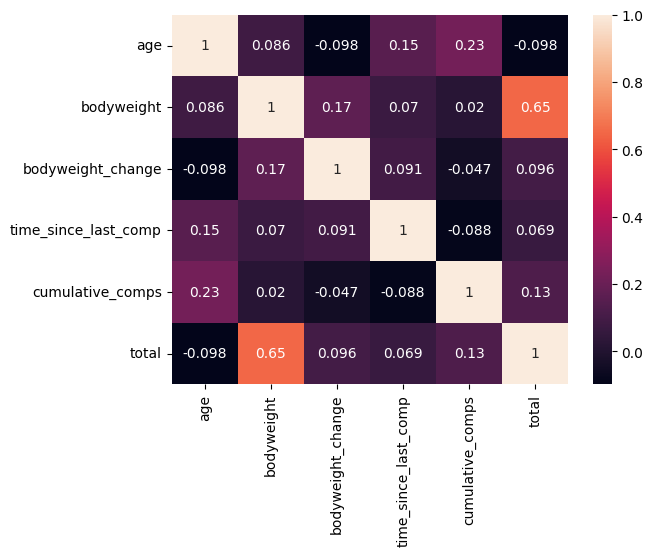

In [144]:
sns.heatmap(correlation_df, annot=True)

In [145]:

# Create a scatter plot for each feature against 'total'
plots = [
    alt.Chart(fe_df_numerical).mark_circle().encode(
        x=alt.X(f'{feature}:Q', title=feature),
        y=alt.Y('total:Q', title='Total'),
        tooltip=[feature, 'total']
    ).properties(
        width=200,
        height=200,
        title=f'Total vs {feature}'
    )
    for feature in numerical_cols
]

In [146]:
alt.hconcat(*plots)

alt.HConcatChart(...)

## Modelling

In [147]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [148]:
param_grid = {
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}


In [149]:
fe_df.schema

{'date': Date,
 'name': Utf8,
 'sex': Utf8,
 'place': Int32,
 'age': Float64,
 'age_class': Utf8,
 'bodyweight': Float64,
 'meet_country': Utf8,
 'equipment': Utf8,
 'squat': Float64,
 'bench': Float64,
 'deadlift': Float64,
 'total': Float64,
 'wilks': Float64,
 'meet_name': Utf8,
 'origin_country': Utf8,
 'year_of_birth': Utf8,
 'primary_key': Utf8,
 'time_since_last_comp': Int32,
 'bodyweight_change': Float64,
 'years_since_last_comp': Float64,
 'is_origin_country': Boolean,
 'date_as_ordinal': Int64,
 'cumulative_comps': UInt32,
 'meet_type': Utf8,
 'squat_progress': Float64,
 'bench_progress': Float64,
 'deadlift_progress': Float64,
 'total_progress': Float64,
 'wilks_progress': Float64}

In [150]:
features = [
    "date_as_ordinal", "name", "sex", "age", "age_class", "bodyweight", "equipment", "total", "place", "time_since_last_comp", "squat_progress", "bench_progress", "deadlift_progress", "total_progress", "wilks_progress", "origin_country", "is_origin_country", "meet_type", "cumulative_comps","bodyweight_change"
]

target = [
    "total"
]


# Preprocessing steps for numeric features
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Preprocessing steps for categorical features
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])


# Preprocessing steps for label encoded features
ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, ['age', 'bodyweight','time_since_last_comp', "squat_progress", "bench_progress", "deadlift_progress", "total_progress", "wilks_progress", 'date_as_ordinal', 'total', 'bodyweight_change', 'cumulative_comps']),
    ('categorical', categorical_transformer, ['sex', 'is_origin_country']),
    ('ordinal', ordinal_transformer, ['place', 'name', 'age_class', 'origin_country', 'meet_type'])
])

# Create the pipeline with preprocessing steps and the regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [151]:
fe_df.filter(pl.col("name") == 'A. Belevskiy')

date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country,year_of_birth,primary_key,time_since_last_comp,bodyweight_change,years_since_last_comp,is_origin_country,date_as_ordinal,cumulative_comps,meet_type,squat_progress,bench_progress,deadlift_progress,total_progress,wilks_progress
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,str,i32,f64,f64,bool,i64,u32,str,f64,f64,f64,f64,f64
2016-04-02,"""A. Belevskiy""","""M""",1,17.5,"""18-19""",98.65,"""Kazakhstan""","""Raw""",212.5,147.5,215.0,575.0,351.88,"""Kazakhstan Cla…","""Kazakhstan""","""1998""","""a.-belevskiy-1…",180,4.3,0.492813,true,736056,1,"""local""",25.364583,10.145833,10.145833,45.65625,14.467958


In [152]:
X_train, X_test, y_train, y_test = train_test_split(fe_df[features], fe_df[target], test_size=0.2, random_state=42)

In [153]:
pipeline.fit(X_train.to_pandas(), y_train.to_pandas())

/Users/namtonthat/Library/Caches/pypoetry/virtualenvs/powerlifting-ml-progress-4gf5U7T4-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
# Initialize the grid search model
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search model
grid_search.fit(X_train.to_pandas(), y_train.to_pandas())

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train.to_pandas(), y_train.to_pandas())

# Make predictions
y_pred = best_model.predict(X_test.to_pandas())


In [ ]:
print(f"Mean Squared Error: {mse}")